In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [3]:
import pickle

import datasets
import numpy as np
from sklearn.decomposition import PCA
import torch
import transformers
from tqdm.auto import trange, tqdm

from src.datasets.speech_equivalence import SpeechEquivalenceDataset
from src.models.integrator import ContrastiveEmbeddingModel, get_sequence
from src.utils.timit import load_or_prepare_timit_corpus

In [4]:
model_checkpoint = "out/ce_model_phoneme_within_word_prefix_6_32/checkpoint-600"
equiv_dataset_path = "data/timit_equiv_phoneme_within_word_prefix_1.pkl"

In [5]:
model = ContrastiveEmbeddingModel.from_pretrained(model_checkpoint)
model.eval()

ContrastiveEmbeddingModel(
  (rnn): RNNModel(
    (rnn): LSTM(768, 32, batch_first=True)
    (fc): Linear(in_features=32, out_features=32, bias=True)
  )
)

In [6]:
with open(equiv_dataset_path, "rb") as f:
    equiv_dataset: SpeechEquivalenceDataset = pickle.load(f)

In [7]:
assert model.is_compatible_with(equiv_dataset)

In [8]:
# Compute representations in batch
model_representations = []

batch_size = 16
non_null_frames = (equiv_dataset.Q != -1).nonzero(as_tuple=True)[0]
F = equiv_dataset.hidden_state_dataset.get_layer(model.config.base_model_layer)
for batch_start in trange(0, len(non_null_frames), batch_size):
    batch_idxs = non_null_frames[batch_start:batch_start + batch_size]

    batch = torch.stack([get_sequence(F, equiv_dataset.S[idx], idx, model.config.max_length)
                         for idx in batch_idxs])
    lengths = torch.minimum(equiv_dataset.lengths[batch_idxs], torch.tensor(model.config.max_length))
    lengths[lengths == 0] = 1

    with torch.no_grad():
        model_representations.append(model.compute_embeddings(batch, lengths).cpu().numpy())

  0%|          | 0/989 [00:00<?, ?it/s]

In [9]:
model_representations = np.concatenate(model_representations, axis=0)
model_representations.shape

(15824, 32)

In [10]:
assert non_null_frames.shape[0] == model_representations.shape[0]

In [11]:
# Subset representations where we have class labels.
labels = equiv_dataset.Q[non_null_frames]
readable_labels = [equiv_dataset.class_labels[label] for label in labels]

In [12]:
pca = PCA(n_components=2)
model_representations_pca = pca.fit_transform(model_representations)

In [13]:
[x for x in sorted(equiv_dataset.class_labels) if x[0] == "SH"]

[('SH',),
 ('SH', 'AA'),
 ('SH', 'AA', 'K'),
 ('SH', 'AA', 'K', 'S'),
 ('SH', 'AA', 'K', 'T'),
 ('SH', 'AA', 'R'),
 ('SH', 'AA', 'R', 'P'),
 ('SH', 'AH'),
 ('SH', 'AO'),
 ('SH', 'AO', 'N'),
 ('SH', 'AO', 'R'),
 ('SH', 'AO', 'R', 'T'),
 ('SH', 'AO', 'R', 'T', 'AH'),
 ('SH', 'AO', 'R', 'T', 'AH', 'N'),
 ('SH', 'AO', 'R', 'T', 'IH'),
 ('SH', 'AO', 'R', 'T', 'IH', 'D'),
 ('SH', 'AO', 'R', 'T', 'IH', 'D', 'JH'),
 ('SH', 'AO', 'T'),
 ('SH', 'AO', 'T', 'AH'),
 ('SH', 'AO', 'T', 'AH', 'N'),
 ('SH', 'AO', 'T', 'IH'),
 ('SH', 'AO', 'T', 'IH', 'D'),
 ('SH', 'AO', 'T', 'IH', 'D', 'JH'),
 ('SH', 'AW'),
 ('SH', 'AW', 'ER'),
 ('SH', 'AW', 'ER', 'S'),
 ('SH', 'AY'),
 ('SH', 'EH'),
 ('SH', 'EH', 'D'),
 ('SH', 'EH', 'L'),
 ('SH', 'EH', 'L', 'F'),
 ('SH', 'EH', 'L', 'F', 'IH'),
 ('SH', 'EH', 'L', 'F', 'IH', 'SH'),
 ('SH', 'EH', 'L', 'T'),
 ('SH', 'EH', 'L', 'T', 'ER'),
 ('SH', 'ER'),
 ('SH', 'ER', 'B'),
 ('SH', 'ER', 'B', 'ER'),
 ('SH', 'ER', 'B', 'ER', 'T'),
 ('SH', 'ER', 'IH'),
 ('SH', 'ER', 'IH', 'F')

## Plot animation

In [14]:
# TODO look for an interesting cohort trajectory in the stimulus, maybe by looking at counts?
label_trajectories = [
    # # trajectory 1
    # [
    #     # frame 1
    #     ("SH",),
    #     # frame 2
    #     ("SH", "IH"),
    # ],
    # [("SH",), ("SH", "AA"),],
    [("SH",), ("SH", "AO"), ("SH", "AO"), ("SH", "AO", "R")],
    [("SH",), ("SH", "AO"), ("SH", "AO"), ("SH", "AO", "T")],
]

label_idx_trajectories = [
    [equiv_dataset.class_labels.index(label) for label in trajectory]
    for trajectory in label_trajectories
]

# Extract matching model representations for each frame of each trajectory.
trajectory_representations = []
for trajectory in label_idx_trajectories:
    # Select only samples consistent with the end of the trajectory.
    # TODO how? they are different instances
    
    trajectory_representations_i = []
    for label_idx in trajectory:
        idxs = np.where(labels == label_idx)[0]
        trajectory_representations_i.append(model_representations_pca[idxs])

    trajectory_representations.append(trajectory_representations_i)

In [15]:
list(zip(["-".join(" ".join(x) for x in traj) for traj in label_trajectories],
         [traj[-1].shape[0] for traj in trajectory_representations]))

[('SH-SH AO-SH AO-SH AO R', 2), ('SH-SH AO-SH AO-SH AO T', 3)]

In [16]:
%matplotlib ipympl

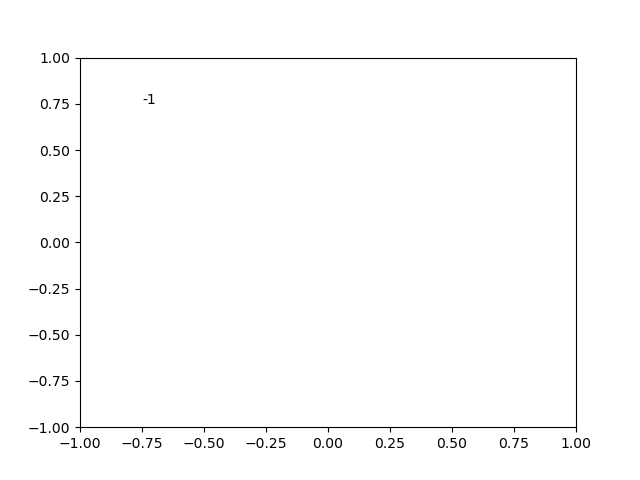

In [17]:
# Animate
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig, ax = plt.subplots()
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
annot_frame = ax.text(-0.75, 0.75, "-1")
scats = [ax.scatter([], []) for _ in trajectory_representations]

def init():
    for scat in scats:
        scat.set_offsets(np.zeros((0, 2)))
    return tuple(scats)

def update(frame):
    for scat, trajectory in zip(scats, trajectory_representations):
        scat.set_offsets(trajectory[frame])
    annot_frame.set_text(str(frame))
    return tuple(scats) + (annot_frame,)

ani = animation.FuncAnimation(fig, update, frames=len(label_trajectories[0]), interval=500,
                              init_func=init, blit=True)
plt.show()

## Plot matched phonemes in different contexts

In [ ]:
target_phoneme = "N"

In [7]:
import numpy as np
np.intersect1d([1, 2, 3, 4, 5, 7], [1, 5])

array([1, 5])

In [ ]:
matching_label_idxs = [idx for idx, label in enumerate(equiv_dataset.class_labels) if label[-1] == target_phoneme]

phoneme_reprs = [model_representations[labels == idx] for idx in matching_label_idxs]
phoneme_labels = [np.repeat(equiv_dataset.class_labels[idx], len(repr))
                  for idx, repr in zip(matching_label_idxs, phoneme_reprs)]
phoneme_reprs = np.concatenate(phoneme_reprs)
phoneme_labels = np.concatenate(phoneme_labels)

In [ ]:
phoneme_reprs_pca = PCA(n_components=2).fit_transform(phoneme_reprs)

AttributeError: 'tuple' object has no attribute 'endswith'

In [ ]:
f, ax = plt.subplots()
ax.scatter(phoneme_reprs_pca[:, 0], phoneme_reprs_pca[:, 1])

annotate_idxs = np.random.choice(len(phoneme_reprs), 10, replace=False)
for idx in annotate_idxs:
    ax.annotate(" ".join(phoneme_labels[idx]), phoneme_reprs_pca[idx])